# Testing Functions of QuickNN

The **QuickNN** library provides a collection of tools and functionalities for building and testing neural network models with ease. To ensure the reliability and correctness of the models and utility functions, This notebook includes a set of predefined testing functions of QuickNN's Models.

## Libraries

In [11]:
from QuickNN.dnn_text_classifier import DNNTextClassifier
from QuickNN.cnn_classifier import CNNClassifier
from QuickNN.rnn_forecaster import RNNForecaster
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

## Testing CNN Classifier

Training Batch: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s, batch_loss=2.3179]


Epoch [1/1], Loss: 2.3042, Accuracy: 11.35%


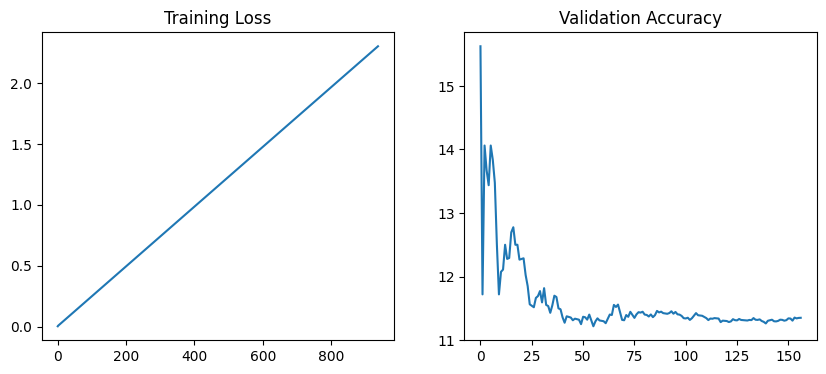

In [ ]:

epochs=1
batch_size=64 
learning_rate=0.01
model = CNNClassifier(num_classes=10)

    # Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
    
    # MNIST dataset
transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert to 3 channels
    ])
    
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training and validation history
train_losses = []
val_accuracies = []
    
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    batch_pbar = tqdm(train_loader, desc=f'Training Batch', leave=True)
    for images, labels in batch_pbar:
        images, labels = images.to(device), labels.to(device)
            
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()          
        running_loss += loss.item()
        batch_pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
            
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation
    model.eval()
    correct = 0
    total = 0
    val_pbar = tqdm(test_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            accuracy = 100 * correct / total
            val_accuracies.append(accuracy)
            val_pbar.set_postfix({'accuracy': f'{accuracy:.2f}%'})
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    # Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.show()

## Testing RNN Forecaster

Epochs: 100%|██████████| 50/50 [00:17<00:00,  2.78it/s, train_loss=0.0025, test_loss=0.0022]


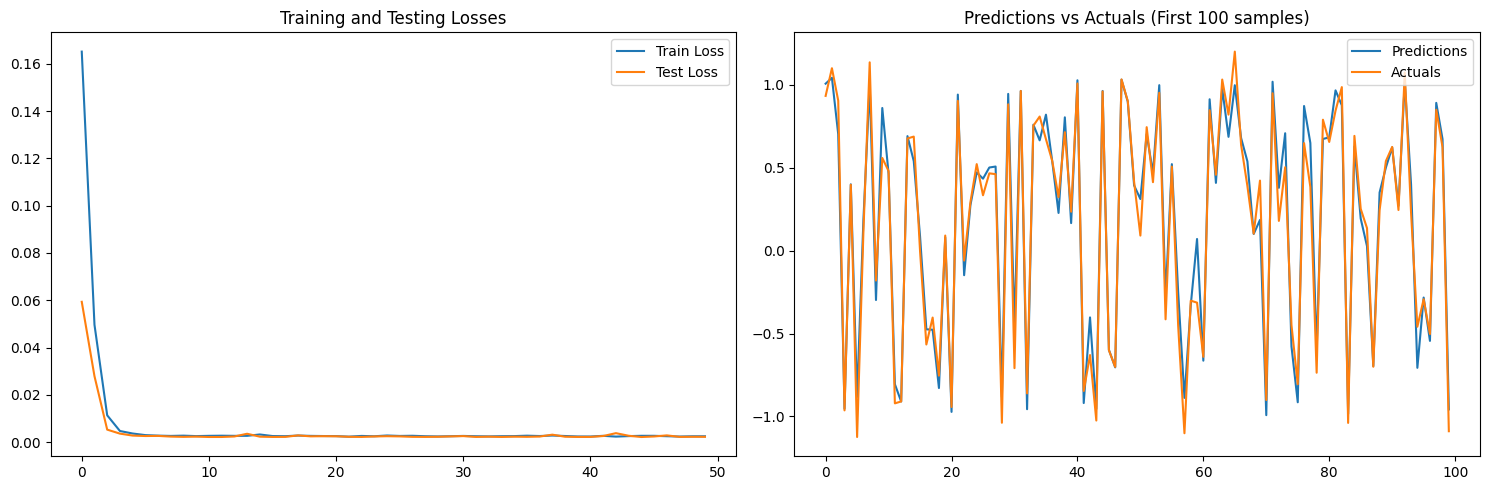

In [10]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.FloatTensor(data)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length], 
                self.data[idx+self.seq_length])

def test_rnn_forecaster(model, data, seq_length=10, epochs=50, batch_size=32, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Data preprocessing
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data.reshape(-1, 1))
    
    # Create dataset
    dataset = TimeSeriesDataset(data_normalized, seq_length)
    train_size = int(len(dataset) * 0.8)
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, len(dataset) - train_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    epoch_pbar = tqdm(range(epochs), desc='Epochs')
    for epoch in epoch_pbar:
        # Training
        model.train()
        running_loss = 0.0
        batch_pbar = tqdm(train_loader, desc='Training', leave=False)
        
        for sequences, targets in batch_pbar:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_pbar.set_postfix({'loss': loss.item()})
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0.0
        predictions = []
        actuals = []
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing', leave=False)
            for sequences, targets in test_pbar:
                sequences, targets = sequences.to(device), targets.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(targets.cpu().numpy())
                
                test_pbar.set_postfix({'loss': loss.item()})
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        epoch_pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'test_loss': f'{test_loss:.4f}'
        })
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.legend()
    plt.title('Training and Testing Losses')
    
    plt.subplot(1, 2, 2)
    predictions = scaler.inverse_transform(np.array(predictions))
    actuals = scaler.inverse_transform(np.array(actuals))
    plt.plot(predictions[:100], label='Predictions')
    plt.plot(actuals[:100], label='Actuals')
    plt.legend()
    plt.title('Predictions vs Actuals (First 100 samples)')
    
    plt.tight_layout()
    plt.show()
    
    return model, predictions, actuals
    # Generate sample data
t = np.linspace(0, 100, 1000)
data = np.sin(0.1 * t) + np.random.normal(0, 0.1, 1000)
    
model = RNNForecaster(input_size=1)
trained_model, preds, acts = test_rnn_forecaster(model, data)

## Testing DNN Text Classifier

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s, train_loss=0.0019, train_acc=100.00%, test_acc=51.50%]


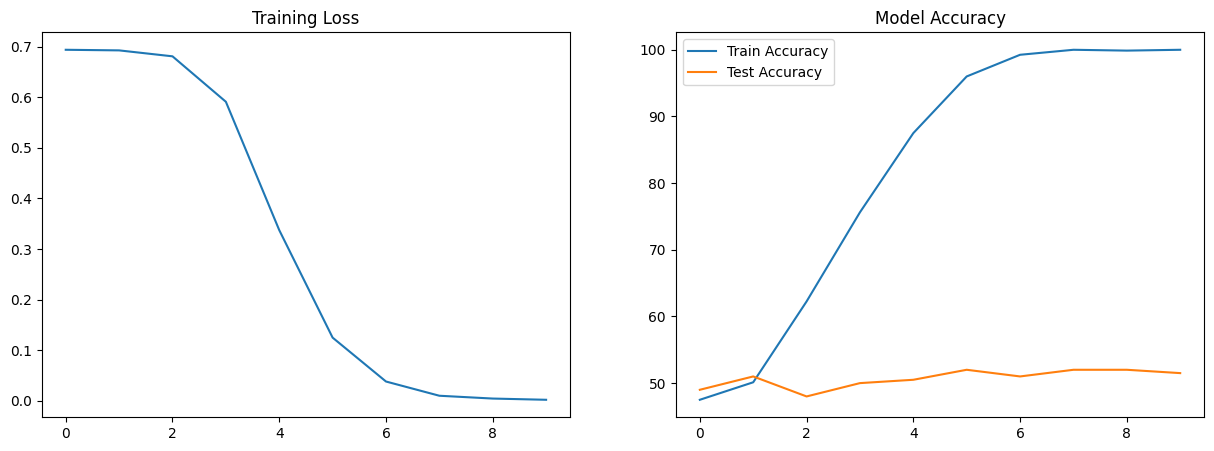

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def test_dnn_classifier(model, texts, labels, epochs=10, batch_size=32, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2)
    
    train_dataset = TextDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
    test_dataset = TextDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    epoch_pbar = tqdm(range(epochs), desc='Epochs')
    for epoch in epoch_pbar:
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        batch_pbar = tqdm(train_loader, desc='Training', leave=False)
        for texts, labels in batch_pbar:
            texts, labels = texts.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            batch_pbar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Testing
        model.eval()
        correct = 0
        total = 0
        test_pbar = tqdm(test_loader, desc='Testing', leave=False)
        
        with torch.no_grad():
            for texts, labels in test_pbar:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                test_pbar.set_postfix({
                    'acc': 100 * correct / total
                })
        
        test_acc = 100 * correct / total
        test_accs.append(test_acc)
        
        epoch_pbar.set_postfix({
            'train_loss': f'{train_loss:.4f}',
            'train_acc': f'{train_acc:.2f}%',
            'test_acc': f'{test_acc:.2f}%'
        })
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.show()
    
    return model

# Example usage
vocab_size = 10000
num_classes = 2
sample_texts = np.random.randint(0, vocab_size, (1000, 100))
sample_labels = np.random.randint(0, num_classes, 1000)
    
model = DNNTextClassifier(vocab_size, num_classes)
trained_model = test_dnn_classifier(model, sample_texts, sample_labels)